STOCK MARKET PREDICTION AND FORECASTING USING STACKED LSTM

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')


In [ ]:
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [ ]:
# Prepare the data
data = df['Close'].values
data = data.reshape(-1, 1)


In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [ ]:
# Split the data into training and testing sets
training_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:training_size]
test_data = scaled_data[training_size:]

In [ ]:
# Create a function to prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)


In [ ]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Build the stacked LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Train the model
model.fit(X_train, Y_train, epochs=100, batch_size=64, verbose=1)


Epoch 1/100
25/25 [==============================] - 9s 97ms/step - loss: 0.0277
Epoch 2/100
25/25 [==============================] - 2s 97ms/step - loss: 0.0026
Epoch 3/100
25/25 [==============================] - 3s 108ms/step - loss: 0.0016
Epoch 4/100
25/25 [==============================] - 4s 150ms/step - loss: 0.0015
Epoch 5/100
25/25 [==============================] - 2s 97ms/step - loss: 0.0015
Epoch 6/100
25/25 [==============================] - 2s 98ms/step - loss: 0.0014
Epoch 7/100
25/25 [==============================] - 2s 99ms/step - loss: 0.0014
Epoch 8/100
25/25 [==============================] - 3s 107ms/step - loss: 0.0013
Epoch 9/100
25/25 [==============================] - 4s 147ms/step - loss: 0.0012
Epoch 10/100
25/25 [==============================] - 2s 96ms/step - loss: 0.0013
Epoch 11/100
25/25 [==============================] - 2s 97ms/step - loss: 0.0011
Epoch 12/100
25/25 [==============================] - 2s 96ms/step - loss: 0.0010
Epoch 13/100
25/25 [=

In [ ]:
# Predict and inverse transform the predicted values
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)


11/11 [==============================] - 0s 34ms/step


In [ ]:
# Calculate RMSE
import math
from sklearn.metrics import mean_squared_error
train_rmse = math.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(Y_test, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train RMSE: 165.35726829365785
Test RMSE: 106.12875479070466


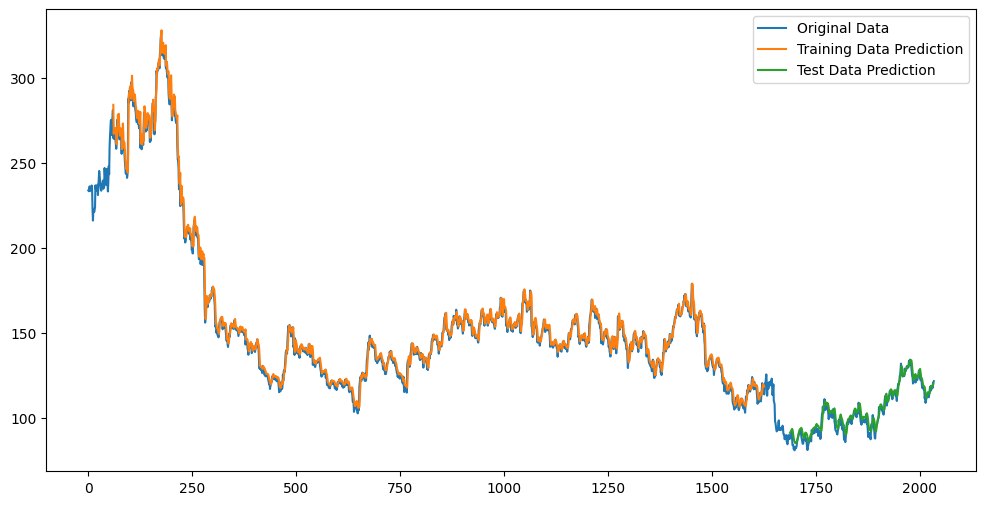

In [ ]:
# Plot the results
look_back = time_step
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(train_plot, label='Training Data Prediction')
plt.plot(test_plot, label='Test Data Prediction')
plt.legend()
plt.show()

In [ ]:
# Predict the next 30 days
def predict_next_days(last_sequence, model, n_steps):
    predicted_prices = []
    current_sequence = last_sequence
    for _ in range(n_steps):
        prediction = model.predict(current_sequence.reshape(1, time_step, 1))
        predicted_prices.append(prediction[0, 0])
        current_sequence = np.append(current_sequence[1:], prediction, axis=0)
    return predicted_prices


In [ ]:
# Get the last sequence from the test data
last_sequence = scaled_data[-time_step:]
next_30_days_scaled = predict_next_days(last_sequence, model, 30)
next_30_days = scaler.inverse_transform(np.array(next_30_days_scaled).reshape(-1, 1))

1/1 [==============================] - 0s 28ms/step


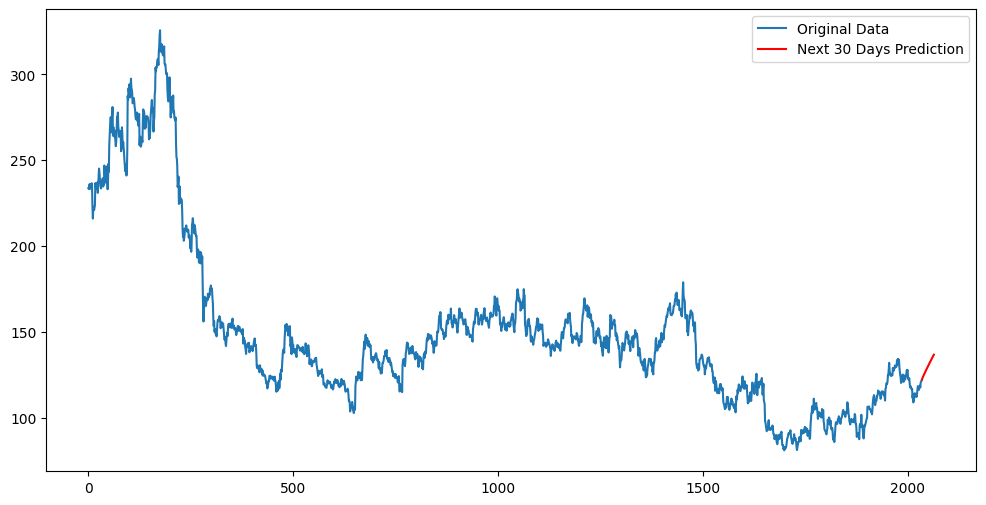

In [ ]:
# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(np.arange(len(scaled_data), len(scaled_data) + 30), next_30_days, label='Next 30 Days Prediction', color='red')
plt.legend()
plt.show()